In [9]:
using Falcons
using Healpix
using Plots
using NPZ
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StaticArrays
using PyPlot
using Formatting
using ReferenceFrameRotations
using LinearAlgebra
using ProgressMeter
using HDF5

hp = pyimport("healpy")
np = pyimport("numpy")
pd = pyimport("pandas")

PyObject <module 'pandas' from '/home/cmb/yusuket/.julia/conda/3/lib/python3.8/site-packages/pandas/__init__.py'>

In [2]:
day = 60 * 60 * 24
year = day * 365

ss = gen_ScanningStrategy()
ss.nside = 128
ss.duration = year #[sec]
ss.sampling_rate = 1 #[Hz]
ss.FP_theta = [0]#mft_focalplane_pointings[:,3]
ss.FP_phi = [0]#mft_focalplane_pointings[:,4].+90
ss.alpha = 45 #[degree]
ss.beta = 50 #[degree]
ss.prec_rpm = period2rpm(192.348) #[sec]
ss.spin_rpm = 0.05 #[rpm]
ss.hwp_rpm = 0 #[rpm]
ss.start_point = "equator";

In [3]:
nside2npix(ss.nside)/4ss.nside

384.0

In [29]:
rpm2angfreq(rpm) = (2.0π / 60.0) * rpm
function get_psiDataBase(SS::ScanningStrategy,; division::Int, idx, map_div)
    #=
    divisionはtodの分割計算
    idxはマップ(npix)をRingOrderでmap_div*nside個の領域に分割したときに北極から順に貼られるインデックス
    map_divはマップをmap_div*nside個に分割するためのパラメータ(4くらいがいい)
    =#
    
    resol = Resolution(SS.nside)
    npix = nside2npix(SS.nside)
    map_division = map_div*SS.nside
    println("To get a psi database in full-sky, specify idx in the range of [1, $map_division] and run the job.")
    
    split = npix/map_division
    month = Int(SS.duration / division)
    ω_hwp = rpm2angfreq(SS.hwp_rpm)
    hit_map = zeros(npix)
    
    psi_db = [Float64[] for i in 1:split]
    under = Int(split*(idx-1))
    upper = Int(split*idx)
    println("ipix_range=[$(under+1),$upper]")
    
    BEGIN = 0
    p = Progress(division)
    @views @inbounds for i = 1:division
        END = i * month
        pix_tod, psi_tod, time_array = get_pointing_pixels(SS, BEGIN, END)
        @views @inbounds for j = eachindex(psi_tod[1,:])
            pix_tod_jth_det = pix_tod[:,j]
            psi_tod_jth_det = ifelse(ω_hwp == 0.0, -psi_tod[:,j], psi_tod[:,j])
            @views @inbounds @simd for k = eachindex(psi_tod[:,1])
                t = time_array[k]
                ipix = pix_tod_jth_det[k]
                psi = psi_tod_jth_det[k]
                hwp_ang = 4ω_hwp*t
                hit_map[ipix] += 1
                if under < ipix <= upper
                    push!(psi_db[ipix-under], psi)
                end
            end
        end
        BEGIN = END
        next!(p)
    end
    return psi_db, hit_map
end


function get_psiDataBase2(SS::ScanningStrategy,; division::Int, idx, map_div)
    #=
    divisionはtodの分割計算
    idxはマップ(npix)をRingOrderでmap_div*nside個の領域に分割したときに北極から順に貼られるインデックス
    map_divはマップをmap_div*nside個に分割するためのパラメータ(4くらいがいい)
    =#
    
    resol = Resolution(SS.nside)
    npix = nside2npix(SS.nside)
    map_division = map_div*SS.nside
    println("To get a psi database in full-sky, specify idx in the range of [1, $map_division] and run the job.")
    
    split = npix/map_division
    month = Int(SS.duration / division)
    ω_hwp = rpm2angfreq(SS.hwp_rpm)
    #hit_map = zeros(npix)
    
    psi_db = [Float64[] for i in 1:split]
    under = Int(split*(idx-1))
    upper = Int(split*idx)
    println("ipix_range = [$(under+1),$upper]")
    
    BEGIN = 0
    p = Progress(division)
    @views @inbounds for i = 1:division
        END = i * month
        pix_tod, psi_tod, time_array = get_pointing_pixels(SS, BEGIN, END)
        @views @inbounds for j = eachindex(psi_tod[1,:])
            pix_tod_jth_det = pix_tod[:,j]
            psi_tod_jth_det = ifelse(ω_hwp == 0.0, -psi_tod[:,j], psi_tod[:,j])
            @views @inbounds @simd for k = eachindex(psi_tod[:,1])
                t = time_array[k]
                ipix = pix_tod_jth_det[k]
                psi = psi_tod_jth_det[k]
                #hwp_ang = 4ω_hwp*t
                #hit_map[ipix] += 1
                if under < ipix <= upper
                    push!(psi_db[ipix-under], psi)
                end
            end
        end
        BEGIN = END
        next!(p)
    end
    return (map_div, idx, psi_db)
end

get_psiDataBase2 (generic function with 1 method)

In [67]:
db = get_psiDataBase2(ss, division=32*6, idx=1, map_div=3);

To get a psi database in full-sky, specify idx in the range of [1, 384] and run the job.
ipix_range = [1,512]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [58]:
function save_psiDB(db)
    h5open("test.h5", "w") do file
        write(file,"map_div", db[1])
        write(file,"idx", db[2])
        for i in eachindex(db[3])
            #println(i)
            write(file,"/psi/$i", db[3][i])
        end
    end
end
save_psiDB(db)

In [59]:
file = h5open("test.h5", "r")

🗂️ HDF5.File: (read-only) test.h5
├─ 🔢 idx
├─ 🔢 map_div
└─ 📂 psi
   ├─ 🔢 1
   ├─ 🔢 10
   ├─ 🔢 100
   ├─ 🔢 101
   ├─ 🔢 102
   ├─ 🔢 103
   ├─ 🔢 104
   ├─ 🔢 105
   ├─ 🔢 106
   ├─ 🔢 107
   ├─ 🔢 108
   ├─ 🔢 109
   ├─ 🔢 11
   ├─ 🔢 110
   ├─ 🔢 111
   ├─ 🔢 112
   ├─ 🔢 113
   ├─ 🔢 114
   ├─ 🔢 115
   ├─ 🔢 116
   ├─ 🔢 117
   ├─ 🔢 118
   ├─ 🔢 119
   ├─ 🔢 12
   ├─ 🔢 120
   └─ (487 more children)

In [63]:
psi1 = read(file,"psi/1")

349-element Vector{Float64}:
 -0.989312477876666
 -0.5519512496543371
 -1.0997774925792112
 -1.1524055313562553
 -0.5580714865634554
 -0.49816089374972716
 -0.7738032976692696
 -1.1076267342964023
 -1.7400110646782232
 -0.07471859765371358
 -1.0348832843771885
 -1.9092865412140219
 -0.24537030674487204
  ⋮
 -1.3258548924352285
  0.1450225103277126
  0.3073618928469244
 -0.8000419636119525
 -1.3281218484508213
 -0.13435034136140966
 -0.5098048927734599
 -0.658444792203846
 -1.336609112114536
 -0.23912647220471556
 -0.4389128283486619
 -1.1266327757998096

In [7]:
#np.savez_compressed("./test_psi", psi=psi_db[i])
#npzwrite("./test_psi.npz", Dict("psi" => psi_db))

In [8]:
#a = npzread("./test_psi.npz")

In [171]:
outmap = ScanningStrategy2map(ss, 32*6);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:59


In [ ]:
m = zeros(nside2npix(ss.nside))
for i in 1:length(psi_db)
    m[i] = (sum(sin.(2psi_db[i]))/outmap[1][i]).^2 .+ (sum(cos.(2psi_db[i]))/outmap[1][i]).^2
end

In [168]:
12*ss.nside^2

3145728

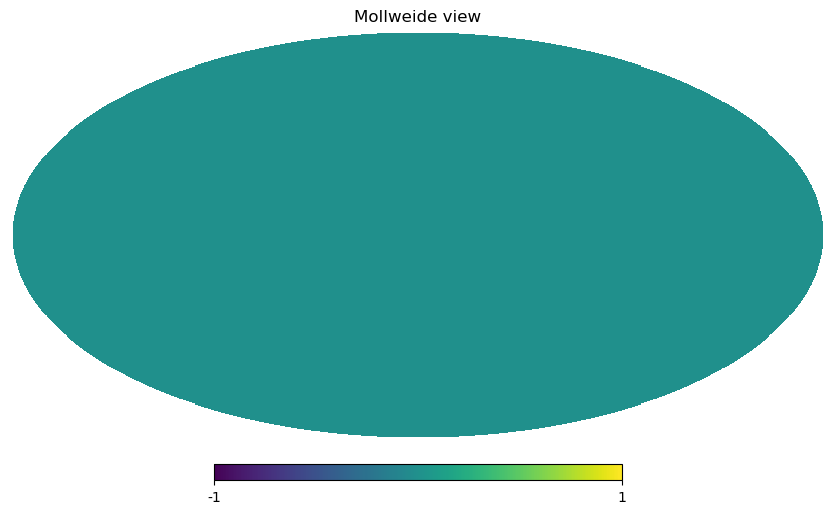

In [169]:
hp.mollview(m)

In [106]:
outmap = ScanningStrategy2map(ss, 4);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


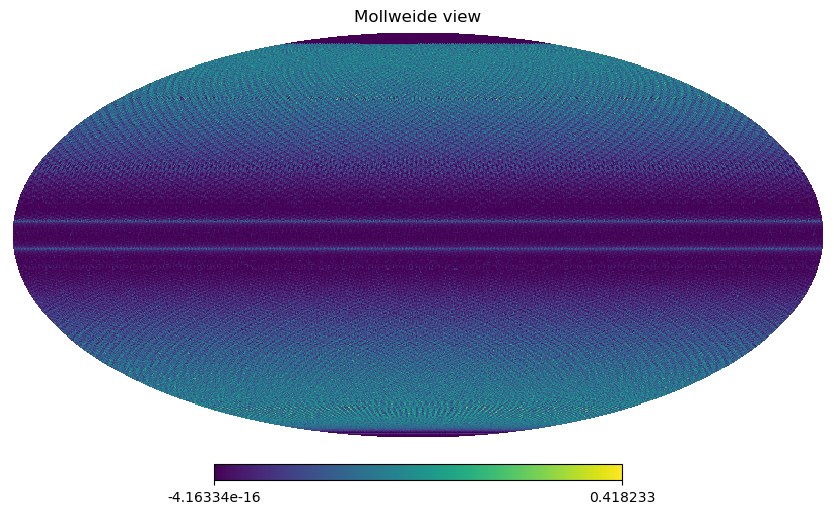

In [107]:
hp.mollview(outmap[3]-m)